In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
#from scipy import stats
#import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from scipy.sparse import hstack
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
#from sklearn.preprocessing import PolynomialFeatures, StandardScaler
#from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures

In [3]:
# Importar pickle con el dataset preprocesado
df = pd.read_pickle('DatasetFinalParaEntrenar.pkl')

### Fit & Transform

In [4]:
# Separar Variables por tipo
categoricals = ['property_type','place_name','state_name','zona']
descriptions = ['texto']
numericals = ['surface_total_in_m2', 'surface_covered_in_m2', 'floor', 'rooms', 'expenses','lat','lon']
dummies = ['subte','colectivo','balcon','tren','porton','financia', 'parrilla','pileta', 'solarium', 'lavadero', 'estacionamiento', 'no_apto_credito','apto_credito', 'amplioliving', 'cocheras', 'frente', 'contrafrente','seguridad', 'amenities', 'SUM', 'espaciosverdes','jacuzzi','estrenar','aptoprofesional','pozo','categoria','reciclado','luminoso','acondicionado','quincho','escalera']
target = ['price_usd_per_m2']

In [5]:
# Separar Train-Test

Xdf = df[np.concatenate([
        categoricals,
        descriptions,
        numericals,
        dummies
])]
Ydf = df[target]

X_trainDf, X_testDf, y_trainDf, y_testDf = train_test_split(Xdf, Ydf, test_size=0.30)

In [6]:
# FIT (función) - Vectorizar categóricas, Vectorizar texto en Description y Normalizar continuas
vectorizer = TfidfVectorizer(min_df=5)
enc = DictVectorizer()
clf = Lasso(0.1, random_state=241,fit_intercept=True)
#lf = LassoCV(alphas=np.linspace(0.01,3, 10), cv=10, fit_intercept=True,n_jobs=-1)
normalizer = preprocessing.Normalizer()
poly = PolynomialFeatures(degree = 1, include_bias = False)

def fit_model(X_train, Y_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.fit_transform(texts[descriptions[0]])
    
    X_train_categ = enc.fit_transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.fit_transform(normalizer.fit_transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies]) # regualirzar las numericas luego de splitear
    
    # train model on data
    clf.fit(X, Y_train)
    return X, Y_train

# X__train, y__train = fit_model(X_trainDf, y_trainDf)

In [ ]:
clf.alpha_

In [ ]:
# TRANSFORM (función)
def transform_model(X_train):
    texts = X_train[descriptions]
    texts = texts.applymap(lambda x: x.lower())
    texts = texts.replace('[^a-zA-Z0-9]', ' ', regex = True)

    X_tfidf = vectorizer.transform(texts[descriptions[0]])
    
    X_train_categ = enc.transform(X_train[categoricals].to_dict('records'))
    
    X_numericas = poly.transform(normalizer.transform(X_train[numericals]))
    
    X_dummies = X_train[dummies]

    X = hstack([X_tfidf, X_train_categ, X_numericas, X_dummies])
    
    return X
X__test = transform_model(X_testDf)
X__test

In [ ]:
# Métricas
from sklearn import metrics
print ('Score de Entrenamiento: ',clf.score(X__train, y__train))
print ('Score de Test: ',clf.score(X__test, y_testDf))
print ('MAE: ', metrics.mean_absolute_error(y_testDf, clf.predict(X__test)))
print ('MSE: ', metrics.mean_squared_error(y_testDf, clf.predict(X__test)))
print ('RMSE: ', np.sqrt(metrics.mean_squared_error(y_testDf, clf.predict(X__test))))
print ('R2: ', metrics.r2_score(y_testDf, clf.predict(X__test)))

In [ ]:
# Cross Validation CV=10
from sklearn.model_selection import cross_val_score
cross_val_score(clf, X__test, y_testDf, cv=10)

In [ ]:
# Ejemplo
print(clf.predict(X__test)[100])
print(y_testDf.iloc[100,0])

### Crear dataset incluyendo predicciones y Ejericio Portafolio

In [7]:
# Reunir sets de entrenamiento y test
X_all, Y_all = fit_model(Xdf, Ydf)
# Calcular predicciones
valores = clf.predict(X_all)

In [17]:
# Volver a fittear el modelo ahora con todos los datos.
valores = clf.predict(X_all)

Ydf - [valores]

,price_usd_per_m2
0,-259.752530
2,-518.024689
4,-25.833915
5,-610.958534
6,178.357211
7,-33.636338
8,-55.560724
10,-465.957953
12,376.803768
13,-869.010585


In [29]:
diferencia = Ydf - [valores]
diferencia.columns = ['diferencia_m2']
diferencia

diferencia.loc[:,'prediccion_m2'] = valores
diferencia.loc[:,'porcentaje_m2'] = Ydf / [valores]

dfR = df.join(diferencia)

dfR.loc[:,'prediccion_valor'] = dfR.prediccion_m2 * dfR.surface_total_in_m2

dfR = dfR[dfR.prediccion_m2 > 0]


portafolio = dfR.sample(n=100,random_state=100)

capital = portafolio.price_aprox_usd.sum()
print(capital)

dfR.sort_values(by='porcentaje_m2', ascending=True, inplace=True)
casas_compradas = pd.DataFrame([], columns=dfR.columns)
i = 0
ahorro = 0
cantidadCasas = len(dfR)
print(cantidadCasas)
while capital > 0:
    if(i > cantidadCasas-1):
        break
    casa = dfR.iloc[i,:]
    valorCasa = casa.price_aprox_usd
    if(capital >= valorCasa):
        ahorro += casa.prediccion_valor - casa.price_aprox_usd
        casas_compradas = casas_compradas.append(casa)
        capital -= valorCasa
    i += 1
    
display(casas_compradas)

# Exportar casos a comprar a CSV
# casas_compradas.to_csv('casas_compradas_lasso.csv')

print('Ahorro total: ', np.round(ahorro, 2))
print(capital)

22558864.232587777
89465


,property_type,place_name,state_name,lat,lon,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,floor,...,reciclado,luminoso,acondicionado,quincho,escalera,texto,diferencia_m2,prediccion_m2,porcentaje_m2,prediccion_valor
50632,house,Dique Luján,Bs.As. G.B.A. Zona Norte,-34.355907,-58.685825,12899.240000,1600.0,1600.0,8.062025,0.0,...,0,0,0,0,0,Casa en Dique Lujan. Cod.951 CODIGO: 1911-951 ...,-1047.593578,1055.655603,0.007637,1.689049e+06
51440,store,Posadas,Misiones,-27.364526,-55.897487,1323.331759,134.0,134.0,9.875610,0.0,...,0,0,0,0,0,LOCAL EN VENTA LOCALVENTA 3 Propiedades ubic...,-1148.183904,1158.059514,0.008528,1.551800e+05
58951,store,Bahía Blanca,Buenos Aires Interior,-38.719276,-62.271595,6231.510000,750.0,750.0,8.308680,0.0,...,0,0,0,0,0,GRAN SALON COMERCIAL - RONDEAU y GUEMES. CODIG...,-961.174882,969.483562,0.008570,7.271127e+05
40576,store,Oberá,Misiones,-27.498997,-55.121959,6231.510000,631.0,390.0,9.875610,0.0,...,0,0,0,0,0,PROPIEDAD CENTRICA EN OBERA CODIGO: 1834-024 u...,-747.898596,757.774206,0.013032,4.781555e+05
104072,house,San Miguel,Bs.As. G.B.A. Zona Norte,-34.542267,-58.713495,5047.530000,456.0,456.0,11.069145,0.0,...,0,0,0,0,0,"Casa - San Miguel DOS DORMITORIOS, COCINA COME...",-830.472063,841.541208,0.013153,3.837428e+05
17301,apartment,Punilla,Córdoba,-31.324047,-64.447243,10655.890000,600.0,600.0,17.759817,0.0,...,0,0,0,0,0,Nºref: 334 -TERRENO EN BIALET MASSE C/INC VIST...,-1021.694019,1039.453835,0.017086,6.236723e+05
28152,apartment,General Rodríguez,Bs.As. G.B.A. Zona Oeste,-34.604656,-58.917285,10655.890000,482.0,482.0,22.107656,0.0,...,0,0,0,0,0,Lote General Rodriguez!!! CODIGO: ubicado en:...,-1136.026700,1158.134356,0.019089,5.582208e+05
19182,house,Belén de Escobar,Bs.As. G.B.A. Zona Norte,-34.346365,-58.781418,17000.000000,914.0,914.0,18.599562,0.0,...,0,0,0,0,0,"Casa 914m², Escobar, Belen de Escobar, por U$S...",-944.485795,963.085357,0.019312,8.802600e+05
68007,store,Burzaco,Bs.As. G.B.A. Zona Sur,-34.827497,-58.389415,80000.000000,3600.0,3600.0,22.222222,0.0,...,0,0,0,0,0,Local en Burzaco LOCAL SOBRE CALLE GORRITTI A ...,-1078.190740,1100.412962,0.020194,3.961487e+06
51890,store,General Rodríguez,Bs.As. G.B.A. Zona Oeste,-34.617390,-58.875983,8412.550000,300.0,300.0,28.041833,0.0,...,0,0,0,0,0,26 LOTES EXCEPCIONALES EN GENERAL RODRIGUEZ. 2...,-1300.402095,1328.443929,0.021109,3.985332e+05


Ahorro total:  170551490.49
7412.1708286574285


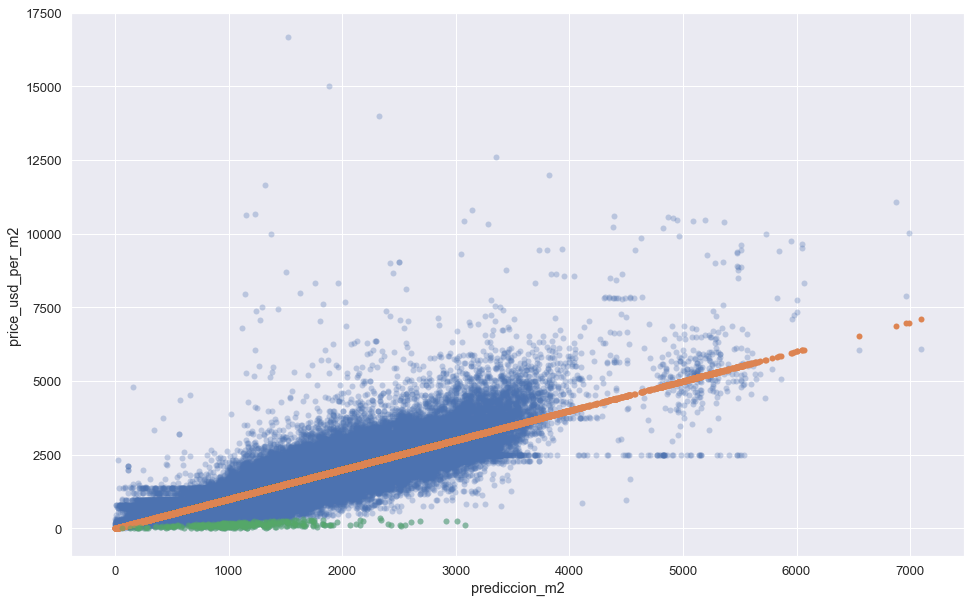

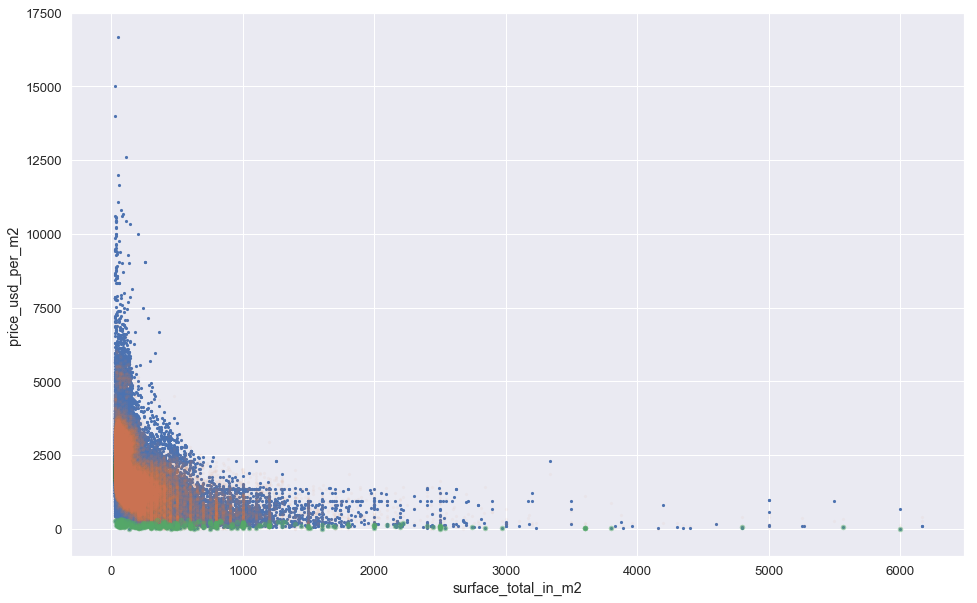

In [77]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})

plt.subplots(figsize=(16,10))

sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=dfR, linewidth=0, alpha=0.3
)
sns.scatterplot(
    x="prediccion_m2", y="prediccion_m2", data=dfR, linewidth=0
)
sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=casas_compradas, linewidth=0, alpha=0.5
)

plt.show()

plt.subplots(figsize=(16,10))
sns.scatterplot(
        x="surface_total_in_m2", y="price_usd_per_m2",
        data=dfR,
        s=10, linewidth=0, alpha=1
)
sns.scatterplot(
        x="surface_total_in_m2", y="prediccion_m2",
        data=dfR,
        s=10, linewidth=0, alpha=0.05,
)
sns.scatterplot(
    x="surface_total_in_m2", y="price_usd_per_m2", data=casas_compradas, linewidth=0, alpha=0.5, s=30
)
plt.show()

In [70]:
dfR.to_csv(r'datasetConPredicciones.csv')

# dfR.loc[:,'prediccion_valor'] = dfR.prediccion_valor.apply(lambda x: round(x,2))

In [54]:
dfR.porcentaje_m2.std()

1.9474570924364694

In [49]:
stdN = dfR.porcentaje_m2.std()
meanN = dfR.porcentaje_m2.mean()

distanciaStd = dfR.porcentaje_m2.apply(lambda x: abs(meanN - x) / stdN)

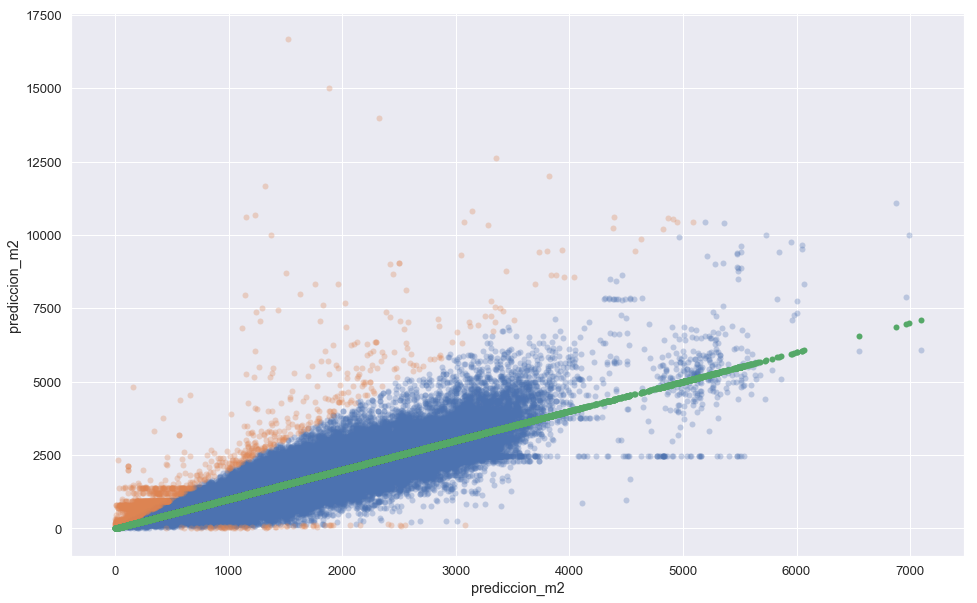

In [51]:
plt.subplots(figsize=(16,10))

sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=dfR[distanciaStd < .5], linewidth=0, alpha=0.3
)
sns.scatterplot(
    x="prediccion_m2", y="price_usd_per_m2", data=dfR[distanciaStd >= .5], linewidth=0, alpha=0.3
)
sns.scatterplot(
    x="prediccion_m2", y="prediccion_m2", data=dfR, linewidth=0
)

In [81]:
feature_array = np.array(vectorizer.get_feature_names())

transformed_text = Xdf[descriptions]
transformed_text = transformed_text.applymap(lambda x: x.lower())
transformed_text = transformed_text.replace('[^a-zA-Z0-9]', ' ', regex = True)
transformed_text = vectorizer.transform(transformed_text[descriptions[0]])

In [107]:
matrix_terms = np.array(vectorizer.get_feature_names())

# Use the axis keyword to sum over rows
matrix_freq = np.asarray(transformed_text.sum(axis=0)).ravel()
final_matrix = np.array([matrix_terms,matrix_freq])


tfidf_sorting = np.argsort(final_matrix).flatten()[::-1]

n = 400
top_n = feature_array[tfidf_sorting][:n]

top_n

array(['no', 'entrada', 'lote', 'centenario', 'sola', 'material', 'oro',
       'peron', '250', 'funes', 'facultad', 'municipal', 'credito',
       'matias', 'paso', 'recepcia', '43', 'descripcion', 'cuadras',
       'ubicacion', '3x3', 'manuel', 'electricidad', 'estimada', 'ramal',
       'premium', 'espa', 'agosto', 'correspondiente', 'recibir',
       'vehiculo', 'unica', 'construir', 'pintado', 'horas', 'prop',
       'meramente', 'metrobus', 'negro', 'principal', 'ph', 'mas', '46',
       'chacabuco', 'chicos', 'adrogue', 'canning', 'cristian', 'zonas',
       'empresa', 'esta', 'hojas', 'bosque', 'nota', 'cuales',
       'colectivo', 'mediante', 'equipamiento', 'alta', 'mts', 'privada',
       '240', 'maschwitz', 'pinamar', 'independientes', '37', 'segun',
       'lindisimo', 'tanque', 'medidas', 'electrogeno', 'descubiertas',
       'persianas', '4to', 'campana', 'andreu', '29', 'sotano', 'hora',
       'cloacas', 'tucuman', 'ubica', 'cortesia', 'vestidor', 'metros',
       'viv